### CHANGES MADE TO CORE CODE 4/07/2019:
comment flatten method

extracted roll axis from flatten - added

added roll axis method - added

take concat out of processor, processor returns 3D array - added

put concat into umap model - added

edit vae in utils to expect a 3d input innit - added


In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import random
import os
import datetime

# Machine learning tools
import umap
from sklearn.linear_model import LinearRegression
import torch
import torch.utils.data
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import ShuffleSplit

# File load and save imports
from utils import *
import segypy 
import pickle

# widget imports
from ipywidgets import interact, VBox, HBox
import ipywidgets as widgets
from IPython.display import clear_output

# Tensor board
from tensorboardX import SummaryWriter

# live loss plots
from livelossplot import PlotLosses

In [2]:
# utils
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def load_seismic(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    seis, header, trace_headers = segypy.readSegy(filename)
    amplitude = seis.reshape(header['ns'], inl.size, crl.size)
    lagtime = trace_headers['LagTimeA'][0]*-1
    twt = np.arange(lagtime, header['dt']/1e3*header['ns']+lagtime, header['dt']/1e3)
    return amplitude, twt

def load_horizon(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    hrz = np.recfromtxt(filename, names=['il','xl','z'])
    horizon = np.zeros((len(inl), len(crl)))
    for i, idx in enumerate(inl):
        for j, xdx in enumerate(crl):
            time = hrz['z'][np.where((hrz['il']== idx) & (hrz['xl'] == xdx))]
            if len(time) == 1:
                horizon[i, j] = time 

    return horizon

def interpolate_horizon(horizon):
    points = []
    wanted = []
    for i in range(horizon.shape[0]):
        for j in range(horizon.shape[1]):
            if horizon[i, j] != 0.:
                points.append([i, j, horizon[i, j]])
            else:
                wanted.append([i, j])
    
    points = np.array(points)
    zs2 = scipy.interpolate.griddata(points[:, 0:2], points[:, 2], wanted, method="cubic")
    for p, val in zip(wanted, zs2):
        horizon[p[0], p[1]] = val
    
    return horizon

def flatten_on_horizon(amplitude, horizon, twt, top_add=12, below_add=52):
    traces = np.zeros((horizon.shape[0], horizon.shape[1], top_add+below_add))
    for i in range(horizon.shape[0]):
        hrz_idx = [np.abs(twt-val).argmin() for val in horizon[i, :]]
        for j in range(horizon.shape[1]):
            traces[i, j, :] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]

    return traces


# VAE functions
class VAE(nn.Module):
    def __init__(self, hidden_size, shape_in):
        super(VAE, self).__init__()
        
#         print('\nINNIT:\nDATA SHAPE:', shape_in)
        # Architecture paramaters
        shape = shape_in[-1] # /2 as will be split into near and far channels
#         print('dimension assumed after split:', shape)
        assert shape%4 == 0, 'input for VAE must be factor of 4'
        reductions = [0.5, 0.5, 0.5]  # specify reduction factor of each convolution
        self.last_conv_channels = 34 # number of channels after last convolution
        
        # find the resultant dimension post convolutional layers
        post_conv = self.post_conv_dim(shape, reductions, self.last_conv_channels)
        self.linear_dimension = post_conv * self.last_conv_channels
        
#         print('Reductions: {}, Number of Channels on last convultion: {}'.format(reductions, self.last_conv_channels))
#         print('Post Conv Dim:', post_conv)
#         print('Input * reductions * channels = Lin dimension:', self.linear_dimension)
#         print('\n')
        
        # Encoder
        self.conv1 = nn.Conv1d(2, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(32, self.last_conv_channels, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(self.linear_dimension, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, self.linear_dimension)
        self.deconv1 = nn.ConvTranspose1d(self.last_conv_channels, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def post_conv_dim(self, in_shape, conv_reductions, last_conv_channels):
        """ Calculates the resultant dimension from convolutions"""
        for i in conv_reductions:
            in_shape = int(np.ceil(in_shape*i)) # calc the resultant size from each conv
        return in_shape    

    def encode(self, x):
#         print('in encode, shape:', x.shape)
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            if mu.is_cuda:
                eps = eps.cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
#         print('in decode, shape before conv(expect linear):', out.shape)
        out = out.view(out.size(0), self.last_conv_channels, int(self.linear_dimension/self.last_conv_channels))
#         print('in decode, after reshape for conv:', out.shape)
        out = self.relu(self.deconv1(out))
#         print('in decode, after conv1:', out.shape)
        out = self.relu(self.deconv2(out))
#         print('in decode, after conv2:', out.shape)
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
#         print('in decode, end shape:', out.shape)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z
    
def loss_function(recon_x, x, mu, logvar, window_size):
    criterion_mse = nn.MSELoss(size_average=False)
#     print('in loss func, window_size:', window_size)
#     print('in loss func, x shape:', x.shape, recon_x.shape)
    MSE = criterion_mse(recon_x.view(-1, 2, window_size), x.view(-1, 2, window_size))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD    
    
# Function to perform one epoch of training
def train(epoch, model, optimizer, train_loader, cuda=False, log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
#         print(data.shape)

        if cuda:
            data = data.cuda()

        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
#         print('In train, data shape:', print(data.shape))
        loss = loss_function(recon_batch, data, mu, logvar, window_size=data.shape[-1])
        loss.backward()
        train_loss += loss.item() * data.size(0)
        optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                        100. * batch_idx / len(train_loader),
#                        loss.item() * data.size(0) / len(train_loader.dataset)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

# Function to perform evaluation of data on the model, used for testing
def test(epoch, model, test_loader, cuda=False, log_interval=10):
    model.eval()
    test_loss = 0
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(test_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, _ = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, data.shape[-1]).item() * data.size(0)

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

# Function to forward_propagate a set of tensors and receive back latent variables and reconstructions
def forward_all(model, all_loader, cuda=False):
    model.eval()
    reconstructions, latents = [], []
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(all_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, z = model(data)
            reconstructions.append(recon_batch.cpu())
            latents.append(z.cpu())
    return torch.cat(reconstructions, 0), torch.cat(latents, 0)

In [5]:
### Client loader
dataholder = DataHolder("Glitne", [1300, 1502, 2], [1500, 2002, 2])
dataholder.add_near('./data/3d_nearstack.sgy');
dataholder.add_far('./data/3d_farstack.sgy');
dataholder.add_horizon('./data/Top_Heimdal_subset.txt')
dataholder.add_well('well_1', 36, 276//2)

SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


In [4]:
class DataHolder:
    def __init__(self, field_name, inlines, xlines):
        
        # User input attributes
        self.field_name = field_name
        self.inlines = inlines
        self.xlines = xlines

        # KEY data for processing
        self.near = None
        self.far = None
        self.twt = None
        self.horizon = None
        
        self.wells = {}
        
    def add_near(self, fname):
        self.near, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        self.twt = twt

    def add_far(self, fname):
        self.far, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        assert (self.twt == twt).all, "This twt does not match the twt from the previous segy"
        
    def add_horizon(self, fname):
        self.horizon = interpolate_horizon(load_horizon(fname, inlines=self.inlines, xlines=self.xlines))
        
    def add_well(self, well_id, well_i, well_x):
        self.wells[well_id] = [well_i, well_x]
           
            
class Processor:
    def __init__(self, Data):
        self.raw = [Data.far, Data.near]
        self.twt = Data.twt
        self.out = None
        
        # attributes
        self.attributes = {'horizon_raw': Data.horizon}
    
    def flatten(self, data, top_add=12, below_add=52):
        out = []
        horizon = self.attributes['horizon_raw']
        
        # input data = [near(twt, x1, x2),far(twt, x1, x2)]
        for amplitude in data:
            # create output trace shape for each set in shape: (twt, x1, x2)
            traces = np.zeros((top_add+below_add, horizon.shape[0],horizon.shape[1]))
            for i in range(horizon.shape[0]):
                # find the corresponding index of the horizon in amplitude twt 'domain'
                hrz_idx = [np.abs(self.twt-val).argmin() for val in horizon[i, :]]
                for j in range(horizon.shape[1]):
                    # place the twt's from above_below horizon into 3rd index
                    traces[:, i, j] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]
            out.append(traces)

        return out # list of far and near, flattened amplitudes shape (twt, x1,x2)
    
    def roll_axis(self, data):
        #input should be (twt,x1,x2)
        for i in range(len(data)):
            data[i] = np.transpose(data[i], (1, 2, 0))
        #output (x1,x2,twt)
        return data
    
    def normalise(self, data):
        well_i=38
        well_x=138
        out = []
        for i in data:
            well_variance = np.mean(np.std(i[well_i - 2:well_i + 1, well_x - 2:well_x + 1], 2))
            i /= well_variance
            out.append(i)

        return out

    def to_2d(self, data):
        return [i.reshape(-1, data[0].shape[-1]) for i in data]
          
    def stack_traces(self, data):
        return np.stack([data[0], data[1]], axis=1)
#         return  np.concatenate([i for i in data], axis=1)
    
    def run_AVO(self):
#         print(self.out[0].shape, self.out[1].shape)
        x_avo = self.out[1]
        y_avo = self.out[0] - self.out[1]

        lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
        lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

        self.attributes['FF'] = y_avo - lin_reg.coef_ * x_avo
        
    def condition_attributes(self):
        # flatten horizon array
        horizon = self.attributes['horizon_raw']
        self.attributes['horizon'] = horizon.reshape(horizon.shape[0]*horizon.shape[1])
        
        # condense fluid factor to min of array
        self.attributes['FF'] = np.min(self.attributes['FF'], 1)
    
    def __call__(self, flatten=False, normalise=False):
        self.out = copy.copy(self.raw)
        
        if flatten[0]:
            self.out = self.flatten(self.out, flatten[1], flatten[2])
            
        self.out = self.roll_axis(self.out)
        
        if normalise:
            self.out = self.normalise(self.out)
        
        # flatten to 2d (traces, amplitudes)
        self.out = self.to_2d(self.out)
        
        # Find fluid factor, add to attributes
        self.FF = self.run_AVO()
        
        # condition attributes to 1d arrays
        self.condition_attributes()
        
        # Stack the traces for output
        self.out = self.stack_traces(self.out)
        print('Processor has made an output with shape: ', self.out.shape)
        

        return [self.out, self.attributes]

In [6]:
class ModelAgent:
    def __init__(self, data):
        self.input = data[0]
        self.attributes = data[1]
        self.embedding = None
        self.input_dimension= self.input.shape[-1]
        
        # for logging
#         today = datetime.date.today()
#         self.path = './runs/{}'.format(today)
#         if not os.path.exists(self.path):
#             os.mkdir(self.path)
#             print("Directory " , self.path ,  " For Logs Created ")
        
        print("ModelAgent initialised")
        

class UMAP(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
        self.name = 'UMAP'
        
    def concat(self):
#         self.input = np.concatenate([self.input[0],self.input[1]], 1)

        self.input = self.input.reshape(-1, 2*self.input_dimension)
        print('to enter UMAP:', self.input.shape)


    def reduce(self, n_neighbors = 50, min_dist=0.001):
        # Directory for logging runs
#         now = datetime.datetime.now().strftime("%I-%M-%S-%p")
#         self.path = self.path + '/{}/'.format(now, self.name)

        self.concat() # concat near_far into 1 dim

        embedding = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation', 
                               verbose=False,
                            random_state=42).fit_transform(self.input)
        
        self.embedding = embedding
        
        print("UMAP 2-D representation complete")
        
    
class VAE_model(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    
    def create_dataloader(self, batch_size=32):
        # create torch tensor
        assert self.input.shape[1] == 2, 'expecting a 3D input'
        X = torch.from_numpy(self.input).float()
        # split the concatenated input back into two arrays
#         X = torch.from_numpy(np.stack(np.split(self.input, 2, axis=1), 1)).float()
        
        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()
        
        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)
        
    def train_vae(self, cuda=False, epochs=5, hidden_size=8, lr=1e-2):
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size, self.input.shape)  # Inititalize the model

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(0.9, 0.999))
        
        liveloss = PlotLosses()
        liveloss.skip_first = 0
        liveloss.figsize = (16,10) #, fig_path=self.path
        liveloss.fig_path = './'
        
        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, cuda=False)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, cuda=False)  # Validate model on test dataset
#             %matplotlib inline
            logs = {}
            logs[ '' + 'ELBO'] = tl
            logs[ 'val_' + 'ELBO'] = testl
            liveloss.update(logs)
            liveloss.draw()      

    def run_vae(self):
        _, self.zs = forward_all(self.model, self.all_loader, cuda=False)
        
    def vae_umap(self, umap_neighbours=50, umap_dist=0.001):
        print('\nVAE->UMAP representation initialised\n')
        transformer = umap.UMAP(n_neighbors=umap_neighbours,
                                min_dist=umap_dist,
                                metric='correlation', verbose=True).fit(self.zs.numpy())
        embedding = transformer.transform(self.zs.numpy())
        print("\n\nVAE -> 2-D UMAP representation complete\n")
        return embedding
    
    def reduce(self, epochs, hidden_size, lr, umap_neighbours, umap_dist):
        if hidden_size < 2: raise Exception('Please use hidden size > 1')

        # Directory for logging runs
        now = datetime.datetime.now().strftime("%I-%M-%S-%p")
        self.path = self.path + '/{}/'.format(now, self.name)
        
        # TODO create text file detailing all hyper parameters.
        
        if not os.path.exists(self.path):
            os.mkdir(self.path)
            print("Directory " , self.path ,  " For Logs Created ")


        self.create_dataloader()
        self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr)
        self.run_vae()
        
        
        # Find 2-D embedding
        if hidden_size > 2:
            self.embedding = self.vae_umap(umap_dist=umap_dist, umap_neighbours=umap_neighbours)
        elif hidden_size == 2:
            self.embedding = self.zs.numpy()


In [7]:
def PlotAgent(model, attr):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set(xlabel='Latent Variable 1', ylabel='Latent Variable 2',
               title='Model used: {}, Trace Attribute: {}'.format(model.name, attr),
               aspect='equal')
        s = ax.scatter(model.embedding[:, 0], model.embedding[:, 1], s=1.0, c=model.attributes[attr])
        c = plt.colorbar(s, shrink=0.7, orientation='vertical')
        c.set_label(label=attr, rotation=90, labelpad=10)
        plt.show()

Processor has made an output with shape:  (25351, 2, 250)
ModelAgent initialised
to enter UMAP: (25351, 500)
UMAP 2-D representation complete


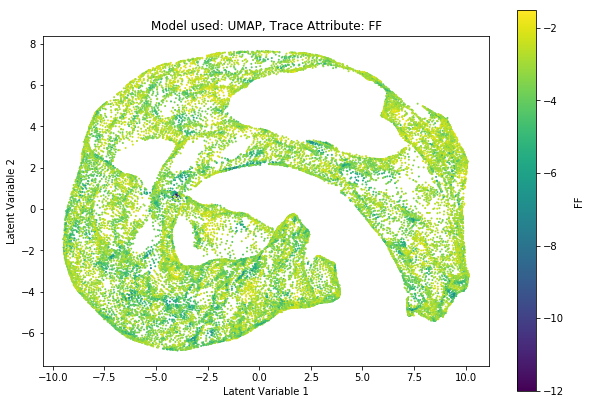

In [8]:
# sanity check to see everything is working
processor = Processor(dataholder)
input12341 = processor([False, 12, 52], normalise=True)
UMAP_a = UMAP(input12341)
UMAP_a.reduce(n_neighbors=50)
PlotAgent(UMAP_a, 'FF')

# EXPAND WINDOW OVER HORIZON:

In [9]:
# Key facts on data set:
mn = dataholder.horizon.min()
mx = dataholder.horizon.max()
mnid = np.abs(dataholder.twt-mn).argmin()
mxid = np.abs(dataholder.twt-mx).argmin()

print('Dataset depth in twt = \t250')
print('Horizon min max index:\t', mnid, ':', mxid)
print('Horizon span:\t\t', mxid - mnid)

Dataset depth in twt = 	250
Horizon min max index:	 134 : 161
Horizon span:		 27


In [10]:
### Processor
processor = Processor(dataholder)

inputs = []
windows = np.arange(2,88, 10)
print(windows)
for i in windows:
    inputs.append(processor([True, i, i], normalise=True))

[ 2 12 22 32 42 52 62 72 82]
Processor has made an output with shape:  (25351, 2, 4)
Processor has made an output with shape:  (25351, 2, 24)
Processor has made an output with shape:  (25351, 2, 44)
Processor has made an output with shape:  (25351, 2, 64)
Processor has made an output with shape:  (25351, 2, 84)
Processor has made an output with shape:  (25351, 2, 104)
Processor has made an output with shape:  (25351, 2, 124)
Processor has made an output with shape:  (25351, 2, 144)
Processor has made an output with shape:  (25351, 2, 164)


ModelAgent initialised
to enter UMAP: (25351, 8)
UMAP 2-D representation complete
window size= 2


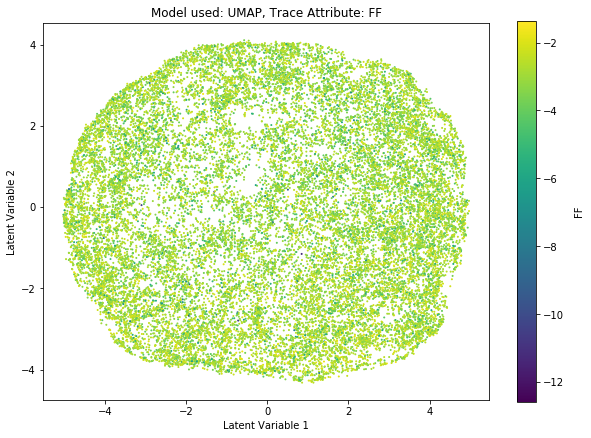

ModelAgent initialised
to enter UMAP: (25351, 48)
UMAP 2-D representation complete
window size= 12


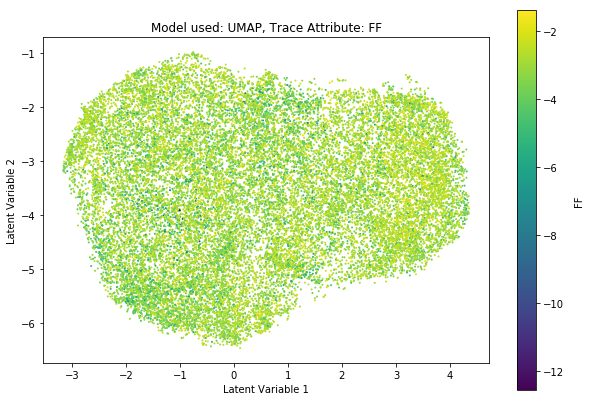

ModelAgent initialised
to enter UMAP: (25351, 88)
UMAP 2-D representation complete
window size= 22


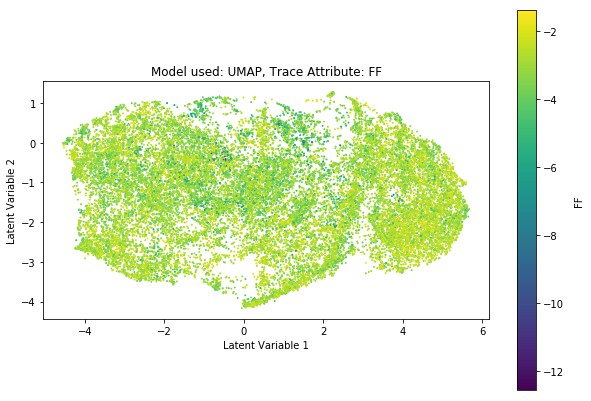

ModelAgent initialised
to enter UMAP: (25351, 128)
UMAP 2-D representation complete
window size= 32


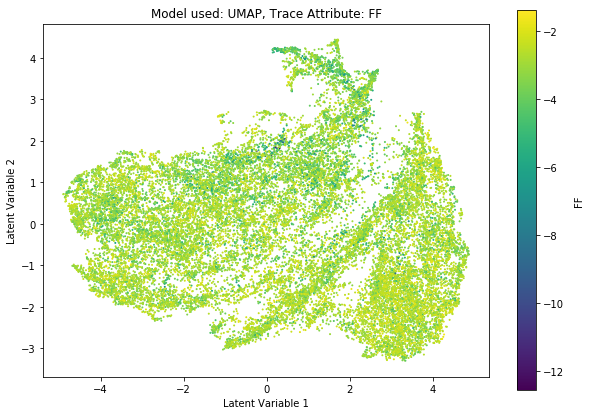

ModelAgent initialised
to enter UMAP: (25351, 168)
UMAP 2-D representation complete
window size= 42


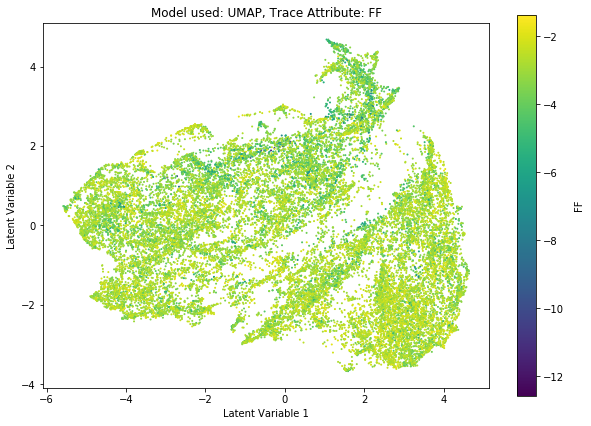

ModelAgent initialised
to enter UMAP: (25351, 208)
UMAP 2-D representation complete
window size= 52


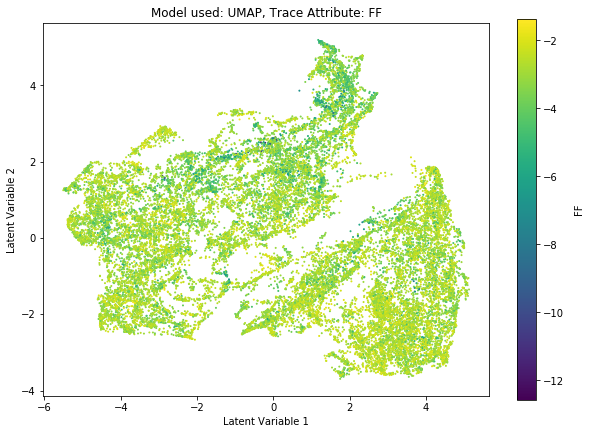

ModelAgent initialised
to enter UMAP: (25351, 248)
UMAP 2-D representation complete
window size= 62


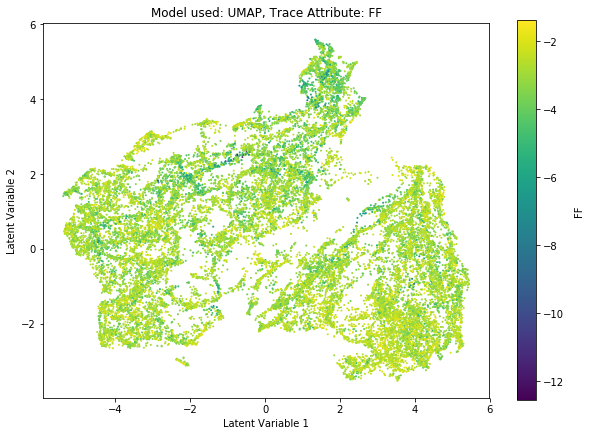

ModelAgent initialised
to enter UMAP: (25351, 288)
UMAP 2-D representation complete
window size= 72


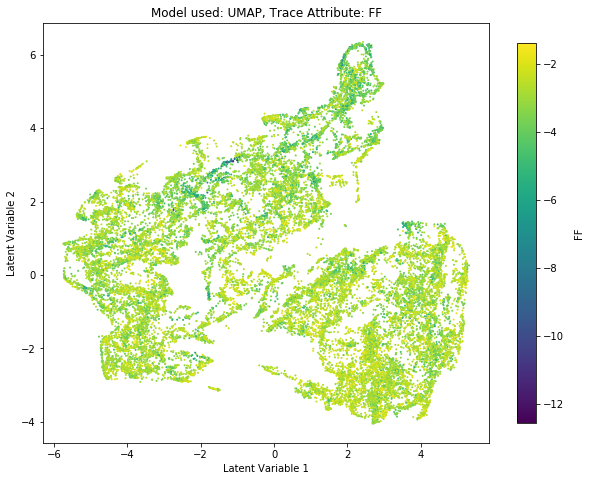

ModelAgent initialised
to enter UMAP: (25351, 328)
UMAP 2-D representation complete
window size= 82


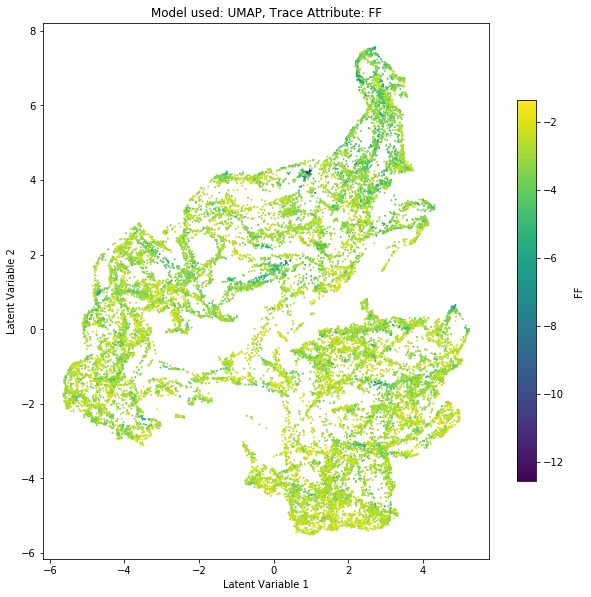

In [12]:
### UMAP RUN
for count,  i in enumerate(inputs):
    UMAP_a = UMAP(i)
    UMAP_a.reduce(n_neighbors=50)
    print('window size=', windows[count])
    PlotAgent(UMAP_a, 'FF')

## SCROLL WINDOW OVER HORIZON:

In [13]:
### Processor
processor = Processor(dataholder)

inputs = []
window = 80

for i in range (0,9):
    print('below add:', i*10, 'above add', window-i*10)
    inputs.append(processor([True, window-i*10, i*10], normalise=True))

below add: 0 above add 80
Processor has made an output with shape:  (25351, 2, 80)
below add: 10 above add 70
Processor has made an output with shape:  (25351, 2, 80)
below add: 20 above add 60
Processor has made an output with shape:  (25351, 2, 80)
below add: 30 above add 50
Processor has made an output with shape:  (25351, 2, 80)
below add: 40 above add 40
Processor has made an output with shape:  (25351, 2, 80)
below add: 50 above add 30
Processor has made an output with shape:  (25351, 2, 80)
below add: 60 above add 20
Processor has made an output with shape:  (25351, 2, 80)
below add: 70 above add 10
Processor has made an output with shape:  (25351, 2, 80)
below add: 80 above add 0
Processor has made an output with shape:  (25351, 2, 80)


ModelAgent initialised
to enter UMAP: (25351, 160)
UMAP 2-D representation complete
window position = 0


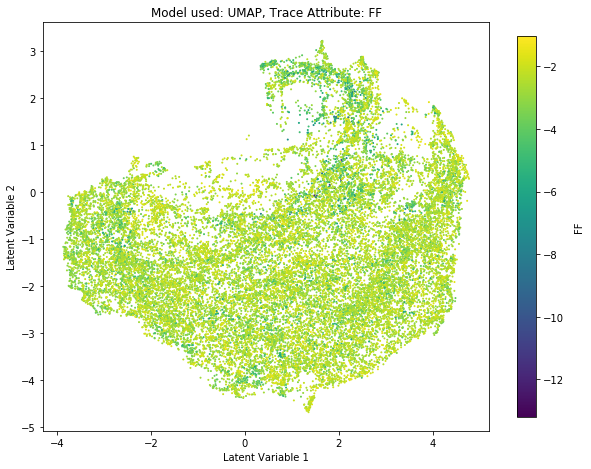

ModelAgent initialised
to enter UMAP: (25351, 160)


In [ ]:
### UMAP RUN
for count,  i in enumerate(inputs):
    UMAP_a = UMAP(i)
    UMAP_a.reduce(n_neighbors=50)
    print('window position =', count*10)
    PlotAgent(UMAP_a, 'FF')

In [ ]:
### Processor
processor = Processor(dataholder)
input123 = processor([False, 0, 0], normalise=True)

window_half = np.arange(15,90, 10)
mid = 147
print(window_half)

man_inputs = []

for i in window_half:
    item = input123[0][:,:,mid-i:mid+i] # create the manual data window for each window half value
    man_inputs.append(item)
    print(item.shape)
    
    
### UMAP RUN
for count,  i in enumerate(window_half):
    input123[0] = man_inputs[count] # manually asign relevant data to the input object
    UMAP_a = UMAP(input123)
    UMAP_a.reduce(n_neighbors=50)
    print('window_half size=', window_half[count])
    PlotAgent(UMAP_a, 'FF')
    PlotAgent(UMAP_a, 'horizon')

# New feature:

In [ ]:
near_stack_amplitudes, twt = load_seismic('./data/3d_nearstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])
far_stack_amplitudes, _ = load_seismic('./data/3d_farstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

In [ ]:
horizon = load_horizon('./data/Top_Heimdal_subset.txt', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

In [ ]:
interpolated_horizon = interpolate_horizon(horizon)

In [ ]:
near_traces = flatten_on_horizon(near_stack_amplitudes, horizon, twt, top_add=12, below_add=52)
far_traces = flatten_on_horizon(far_stack_amplitudes, horizon, twt, top_add=12, below_add=52)

In [ ]:
well_i, well_x = 36, 276//2
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

near_traces /= well_variance_near
far_traces /= well_variance_far

In [ ]:
diff = far_traces - near_traces


In [ ]:
near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb = far_traces.reshape(-1, 64)
diff_traces_emb = diff.reshape(-1, 64)

In [ ]:
stacked = np.concatenate([far_traces_emb, near_traces_emb], 1)
three_features = np.concatenate([far_traces_emb, near_traces_emb, diff_traces_emb], 1)

In [ ]:
#FF
x_avo = near_traces_emb
y_avo = far_traces_emb-near_traces_emb
lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))
FF = y_avo-lin_reg.coef_*x_avo

In [ ]:
def umapit(it):
    plot = umap.UMAP(n_neighbors=50,
                          min_dist=0.001,
                          metric='correlation', 
                                   verbose=True,
                                random_state=42).fit_transform(it)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set(xlabel='Latent Variable 1', ylabel='Latent Variable 2',
           aspect='equal')
    sc = ax.scatter(plot[:, 0], plot[:, 1], s=1.0, c=np.min(FF, 1))
    c = plt.colorbar(sc, shrink=0.7, orientation='vertical')
    c.set_label(label= 'ada', rotation=90, labelpad=10)
    plt.show()
    
    return embedding_stack_ff

In [ ]:
plot = umapit(three_features)